# Neural Networks

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

# Food recognition
import PIL
from os import listdir
from matplotlib import image
from matplotlib import pyplot
from PIL import Image
import pandas as pd


2002 training labels loaded
Start loading 200 images
Loading at 0.0%
Loading at 50.0%
Loading at 100.0%
Reached MAX_IMAGE count of 200
5
train_15.jpg


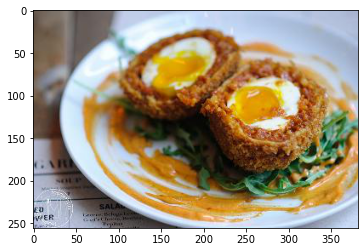

3
train_28.jpg


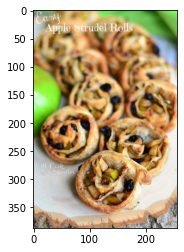

3
train_32.jpg


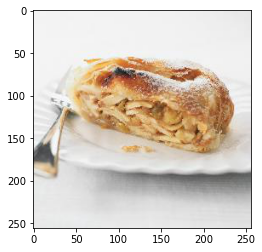

2
train_63.jpg


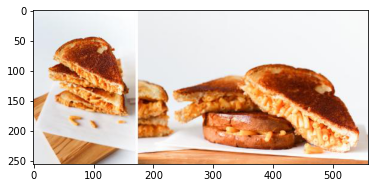

1
train_74.jpg


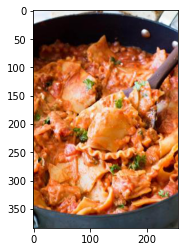

5
train_105.jpg


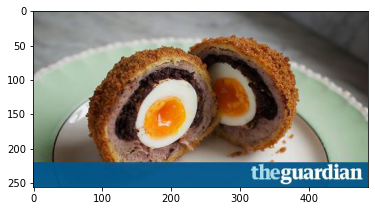

4
train_115.jpg


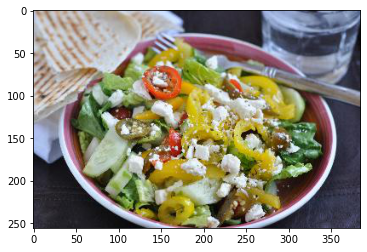

1
train_134.jpg


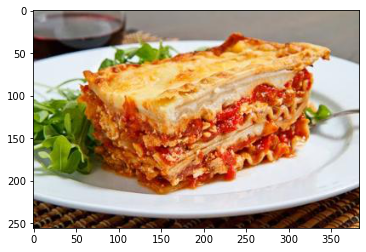

2
train_164.jpg


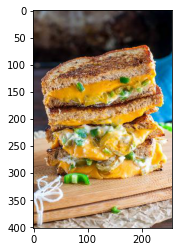

4
train_189.jpg


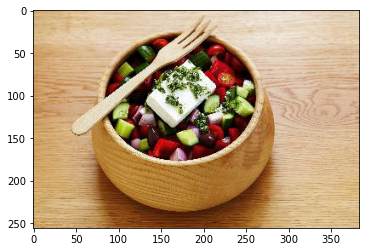

In [2]:
# Local data directories
DATA_DIR = '/Users/dj/Documents/GitHub/Data/food-recognition-challenge-2021'
TRAIN_DIR = DATA_DIR + '/train_set/train_set/'
TEST_DIR = DATA_DIR + '/test_set/test_set/'

# Maximum number of images to load (there are 30k)
MAX_IMAGE = 200

# Filter for a subset of labels in the images to load
FILTER_LABEL = ['1', '2', '3', '4', '5']

# load all the training labels
train_labels = pd.read_csv(DATA_DIR + '/train_labels.csv', dtype={'label': object})
if (len(FILTER_LABEL) > 0):
    train_labels = train_labels[train_labels['label'].isin(FILTER_LABEL)].copy().reset_index()
print('{} training labels loaded'.format(len(train_labels)))  

# load all the training images
train_images = list()
imcount = 0
if MAX_IMAGE == 0:
    MAX_IMAGE = len(train_labels)

print('Start loading {} images'.format(MAX_IMAGE))
for filename in train_labels['img_name']:
    # Load image
    img = Image.open(TRAIN_DIR + filename)
    
    # Resize image to the same shape
    # TODO: Don't squash all images into the same size
    #img = img.resize((256,256), Image.ANTIALIAS)

    # Convert image to numpy array
    img_data = np.array(img)

    # Store loaded image
    train_images.append(img_data)

    # Show progress
    if imcount % 100 == 0:
        print('Loading at {:.1f}%'.format(imcount/min(len(train_labels), MAX_IMAGE)*100))

    # Stop after X images   
    imcount += 1
    if imcount > MAX_IMAGE:
        print('Reached MAX_IMAGE count of '+str(MAX_IMAGE))
        break

# Show 10 samples
for i in range(0,min(10, len(train_labels))):
    print(train_labels['label'][i])
    print(train_labels['img_name'][i])
    pyplot.imshow(train_images[i])
    pyplot.show()

In [6]:
train_images[3].shape

(256, 559, 3)

# Model

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

# Create a training and test set generator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_split = int(len(train_labels)*0.8)
train_dataframe = train_labels[:train_split][['img_name','label']]
val_dataframe = train_labels[train_split:][['img_name','label']]

train_generator = train_datagen.flow_from_dataframe(
    train_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(256,256),
    batch_size=25,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(256,256),
    batch_size=25,
    class_mode='categorical'
)

Found 1601 validated image filenames belonging to 5 classes.
Found 401 validated image filenames belonging to 5 classes.


Using TensorFlow backend.


# Import Base Model

In [5]:
from keras.applications import ResNet50

base_model = ResNet50(input_shape=(256, 256,3), include_top=False, weights="imagenet")

2021-12-02 12:35:47.761259: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 12:35:47.762948: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
/opt/anaconda3/envs/python_env_37/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = Sequential()
base_model.add(ResNet50(input_shape=(256, 256,3), include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(5, activation='softmax'))

base_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
base_model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
history = base_model.fit(train_generator, steps_per_epoch=10, epochs = 5, validation_data = val_generator, validation_steps=5)

Epoch 1/5


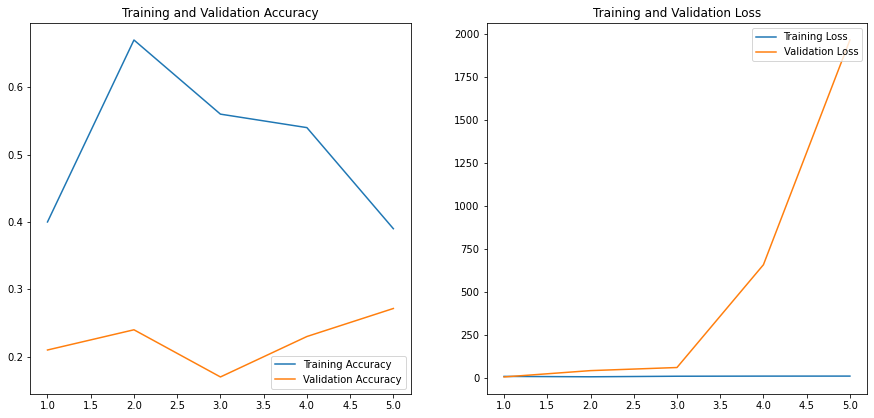

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Running time was 29 min

# New Approach with Pierre

In [4]:
import tensorflow as tf
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = ResNet50(input_shape = (255, 255, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

from keras.optimizers import RMSprop

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(5, activation='softmax'))

base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'CategoricalCrossentropy', metrics = ['acc'])

resnet_history = base_model.fit(train_generator, validation_data = val_generator, steps_per_epoch = 5, epochs = 3)

2021-12-02 16:49:27.359955: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 16:49:27.362693: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
/opt/anaconda3/envs/python_env_37/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


AttributeError: 'CategoricalCrossentropy' object has no attribute 'dtype'